In [1]:
import os
import numpy as np
import sys
sys.path.append('../../scripts/')
sys.path.append('../utils/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'system', colors='banskt')

from readgx import readgx

In [2]:
gxfile = '/scratch/sbanerj/trans-eqtl/input/gtex/expression/gtex_protein_coding_normalized_lmcorrected_ms.txt'
gx, donors, genes = readgx(gxfile)

In [12]:
C = np.cov(gx.T)
C.shape

In [15]:
from scipy.linalg import eigh
W, Q = eigh(C)
Wsparse = W.copy()
Wsparse[np.where(W < 0)] = 0
correct = np.allclose(C, Q @ np.diag(Wsparse) @ Q.T)
print(correct)

True


In [21]:
Apart = Q @ np.diag(np.sqrt(Wsparse))
np.save("gtex_correlation.npy", Apart)

In [2]:
corrfile = '/scratch/sbanerj/trans-eqtl/input/gtex/expression/gtex_correlation.npy'
Bpart = np.load(corrfile)

In [17]:
n = 15158
s = 450
X = np.zeros((n, s))
Xrand = np.random.normal(0, 1, size = s * n).reshape(s, n)
for i in range(s):
    #Xrand = np.random.normal(0, 1, size = n)
    X[:, i] = np.einsum('ij, j', Bpart, Xrand[i, :])

In [18]:
X

array([[ 0.29147271,  1.10272777,  0.39139882, ..., -1.52593881,
        -1.80712914,  0.00870932],
       [-0.72216832, -0.07630472, -2.54758332, ..., -0.03815595,
         1.00864555,  1.29580621],
       [ 1.79654585, -0.13856829,  2.18110938, ..., -1.68057284,
        -2.29415118,  0.57564521],
       ...,
       [ 0.5627416 ,  1.6646195 , -0.04885447, ..., -0.0533507 ,
         1.00788895,  0.62255097],
       [-1.89268649,  0.69414901,  0.50464644, ..., -0.0384388 ,
         0.25341109, -0.77668362],
       [ 0.76388715,  0.30760231, -0.07775384, ..., -1.4456531 ,
        -1.48305083,  0.77631377]])

In [19]:
import time
start_time = time.time()
X_dot = np.dot(Bpart, Xrand.T)
print ("{:g} seconds".format(time.time() - start_time))

2.11418 seconds


In [20]:
start_time = time.time()
X_ein = np.einsum('ij, kj', Bpart, Xrand)
print ("{:g} seconds".format(time.time() - start_time))

127.699 seconds


In [27]:
X_dot

array([[ 0.29147271,  1.10272777,  0.39139882, ..., -1.52593881,
        -1.80712914,  0.00870932],
       [-0.72216832, -0.07630472, -2.54758332, ..., -0.03815595,
         1.00864555,  1.29580621],
       [ 1.79654585, -0.13856829,  2.18110938, ..., -1.68057284,
        -2.29415118,  0.57564521],
       ...,
       [ 0.5627416 ,  1.6646195 , -0.04885447, ..., -0.0533507 ,
         1.00788895,  0.62255097],
       [-1.89268649,  0.69414901,  0.50464644, ..., -0.0384388 ,
         0.25341109, -0.77668362],
       [ 0.76388715,  0.30760231, -0.07775384, ..., -1.4456531 ,
        -1.48305083,  0.77631377]])

In [29]:
np.allclose(X_ein, X_dot)

True

In [10]:
def plot_components(ax, data, xmax, xmin, nbin, ninterp, legend, interp = True, ymax = 0.0):
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], ninterp)
    nrow = data.shape[0]
    ncol = data.shape[1]
    ymaxcal = 0
    for i in range(nrow):
        yhist, _ = np.histogram(data[i, :], bins = bins)
        yfreq = yhist / ncol
        if interp:
            fy = interp1d(xbin, yfreq, kind='cubic')
            y = fy(x)
            ax.plot(x, y, alpha = 0.3)
            ymaxnew = np.max(y)
        else:
            ax.plot(xbin, yfreq, alpha = 0.3)
            ymaxnew = np.max(yfreq)
        if ymaxnew > ymaxcal:
            ymaxcal = ymaxnew
    if ymax == 0:
        ymaxset = round(ymaxcal + 0.05, 1)
    else:
        ymaxset = ymax
    ax.set_ylim([0, ymaxset])
    ax.text(0.1, 0.85, legend, horizontalalignment='left', transform=ax.transAxes)
    return ymaxset

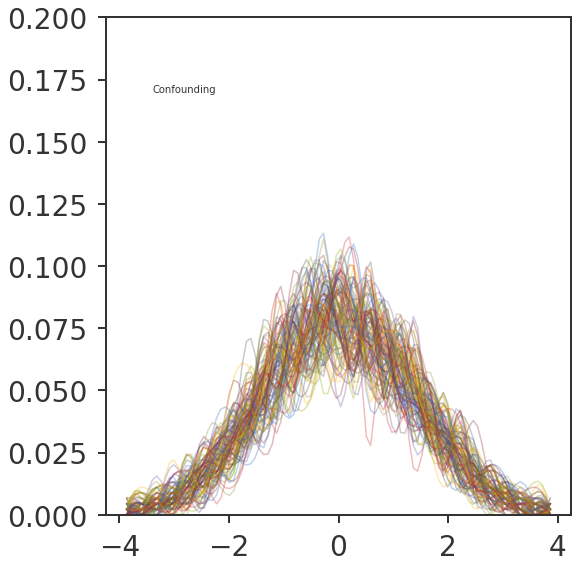

In [33]:
from scipy.interpolate import interp1d

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
nbin = 30
ninterp = 100
ngene_plot = 100
xmax = int(max(abs(np.min(X[:ngene_plot, :])), abs(np.max(X[:ngene_plot, :]))) + 0.5)
xmin = -xmax
plot_components(ax1, (X - Xrand.T)[:ngene_plot, :], xmax, xmin, nbin, ninterp, 'Confounding')
plt.tight_layout()
plt.show()